In [41]:
import yfinance as yf
import requests
from requests.adapters import HTTPAdapter
from urllib3.poolmanager import PoolManager
import ssl

class SSLAdapter(HTTPAdapter):
    def init_poolmanager(self, *args, **kwargs):
        context = ssl.create_default_context()
        context.check_hostname = False
        context.verify_mode = ssl.CERT_NONE
        kwargs['ssl_context'] = context
        return super(SSLAdapter, self).init_poolmanager(*args, **kwargs)

session = requests.Session()
session.mount('https://', SSLAdapter())

# Now pass this session to yfinance
company = "NCC.NS"
company = yf.Ticker(company, session=session)
company = company.history(period='max')

In [42]:
# Inputs 
prediction_period = 20
time_steps = 60
cutoff_date = '2005-01-01'

In [43]:
import pandas as pd
import pandas_ta as ta
import numpy as np

# Calculate technical indicators for each company
company['RSI_14'] = ta.rsi(company['Close'], length=14)
company['EMA_21'] = ta.ema(company['Close'], length=21)
company['EMA_50'] = ta.ema(company['Close'], length=50)
company['SMA_21'] = ta.sma(company['Close'], length=21)
company['SMA_50'] = ta.sma(company['Close'], length=50)
#company['SMA_200'] = ta.sma(company['Close'], length=200)
# Calculate additional technical indicators
company['MACD'] = ta.macd(company['Close'])['MACD_12_26_9']
company['ATR'] = ta.atr(company['High'], company['Low'], company['Close'])
bbands = ta.bbands(company['Close'])
company['Bollinger_High'] = bbands['BBU_5_2.0']
company['Bollinger_Low'] = bbands['BBL_5_2.0']
# Calculate Stochastic Oscillator
stoch = ta.stoch(company['High'], company['Low'], company['Close'])
company['STOCHk'] = stoch['STOCHk_14_3_3']
company['STOCHd'] = stoch['STOCHd_14_3_3']
company['ROC'] = ta.roc(company['Close'])
company['OBV'] = ta.obv(company['Close'], company['Volume'])
company['CMF'] = ta.cmf(company['High'], company['Low'], company['Close'], company['Volume'])

# add some more features
company['Range'] = company['High'] - company['Low']


# Shift the closing price to get the target variable
company['Target1d'] = company['Close'].shift(-prediction_period)
company_original = company.copy()
company.dropna(inplace=True)

In [44]:
company = company[company.index> cutoff_date]

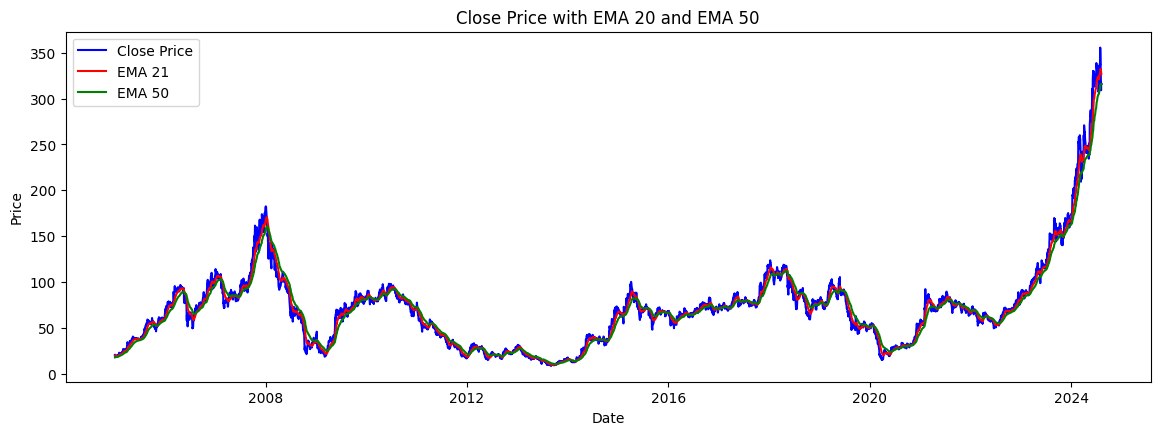

In [45]:
import matplotlib.pyplot as plt
# Set up the plotting area
plt.figure(figsize=(14, 10))

# Plotting the Close Price, EMA20, and EMA50 on the same plot
plt.subplot(2, 1, 1)
plt.plot(company.index, company['Close'], label='Close Price', color='blue')
plt.plot(company.index, company['EMA_21'], label='EMA 21', color='red')
plt.plot(company.index, company['EMA_50'], label='EMA 50', color='green')

plt.title("Close Price with EMA 20 and EMA 50")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

In [46]:
# Features and target
# Update features list
features = [
    'RSI_14', 'EMA_21', 'EMA_50', 'SMA_21', 'SMA_50', 'Close',
    'Volume', 'Range', 'MACD', 'ATR', 'Bollinger_High',
    'Bollinger_Low', 'STOCHd', 'STOCHk', 'ROC', 'OBV', 'CMF'
]

In [47]:
# Define the cutoff date
cutoff_date = '2023-03-30'
# Split the DataFrame into training and testing sets based on the cutoff date
train_data = company[company.index < cutoff_date]
test_data = company[company.index >= cutoff_date]
# Display the shapes to verify
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Shape: (4504, 23)
Testing Data Shape: (332, 23)


In [48]:
# Training and test data
X_train = train_data[features].values
X_test = test_data[features].values
y_train = train_data['Target1d'].values
y_test = test_data['Target1d'].values

In [49]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [50]:
# Scale the features using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit the scalers on training data and transform
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [51]:
# Function to create sequences of data for LSTM
def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [52]:
# Create sequences from training and testing data

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape the data for LSTM [samples, time steps, features]
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")


X_train_seq shape: (4444, 60, 17), y_train_seq shape: (4444, 1)
X_test_seq shape: (272, 60, 17), y_test_seq shape: (272, 1)


In [53]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=50, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Make predictions on the test data
test_predictions = model.predict(X_test_seq)
test_predictions = scaler_y.inverse_transform(test_predictions)

# Inverse transform the actual test targets for comparison
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Create a DataFrame for plotting the test predictions
test_dates = test_data.index[time_steps:]  # Adjust for the shifted time steps
plot_df = pd.DataFrame({
    'Actual Price': y_test_actual.flatten(),
    'Predictions': test_predictions.flatten()
}, index=test_dates)

Epoch 1/50
89/89 [==============================] - 7s 46ms/step - loss: 0.0130 - val_loss: 0.3132
Epoch 2/50
89/89 [==============================] - 3s 35ms/step - loss: 0.0055 - val_loss: 0.2173
Epoch 3/50
89/89 [==============================] - 3s 36ms/step - loss: 0.0050 - val_loss: 0.2952
Epoch 4/50
89/89 [==============================] - 3s 37ms/step - loss: 0.0050 - val_loss: 0.2340
Epoch 5/50
89/89 [==============================] - 3s 32ms/step - loss: 0.0046 - val_loss: 0.2773
Epoch 6/50
89/89 [==============================] - 3s 33ms/step - loss: 0.0047 - val_loss: 0.2780
Epoch 7/50
89/89 [==============================] - 3s 32ms/step - loss: 0.0044 - val_loss: 0.3169
Epoch 8/50
89/89 [==============================] - 3s 33ms/step - loss: 0.0043 - val_loss: 0.2989
Epoch 9/50
89/89 [==============================] - 3s 33ms/step - loss: 0.0042 - val_loss: 0.2872
Epoch 10/50
89/89 [==============================] - 3s 33ms/step - loss: 0.0042 - val_loss: 0.2569
Epoch 11/

In [54]:
# Offset the predictions by 7 days to align them correctly with actual test values
plot_df['Predictions'] = plot_df['Predictions'].shift(prediction_period)

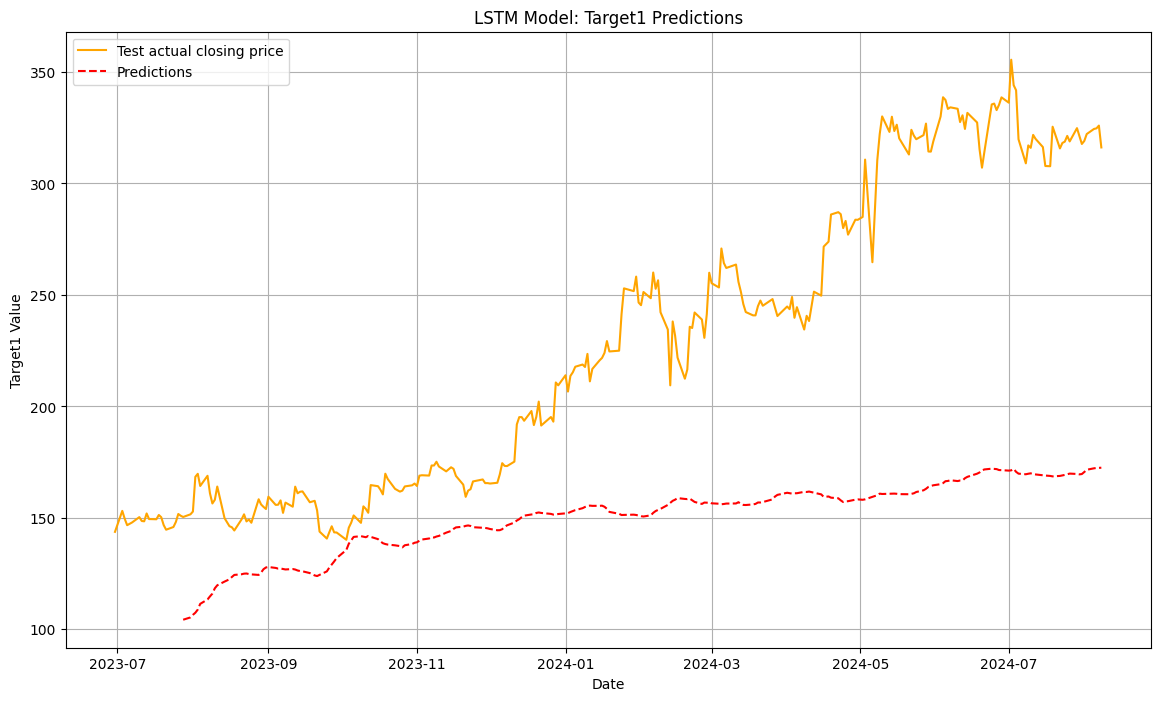

In [55]:
# Plotting
plt.figure(figsize=(14, 8))

# Plot the original target data for visualization
#plt.plot(train_data.index, train_data['Close'], label='Train actual closing price', color='blue')

# Plot the actual test data
plt.plot(plot_df.index, plot_df['Actual Price'], label='Test actual closing price', color='orange')

# Plot the test predictions
plt.plot(plot_df.index, plot_df['Predictions'], label='Predictions', color='red', linestyle='--')

# Adding title and labels
plt.title('LSTM Model: Target1 Predictions')
plt.xlabel('Date')
plt.ylabel('Target1 Value')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 16ms/step


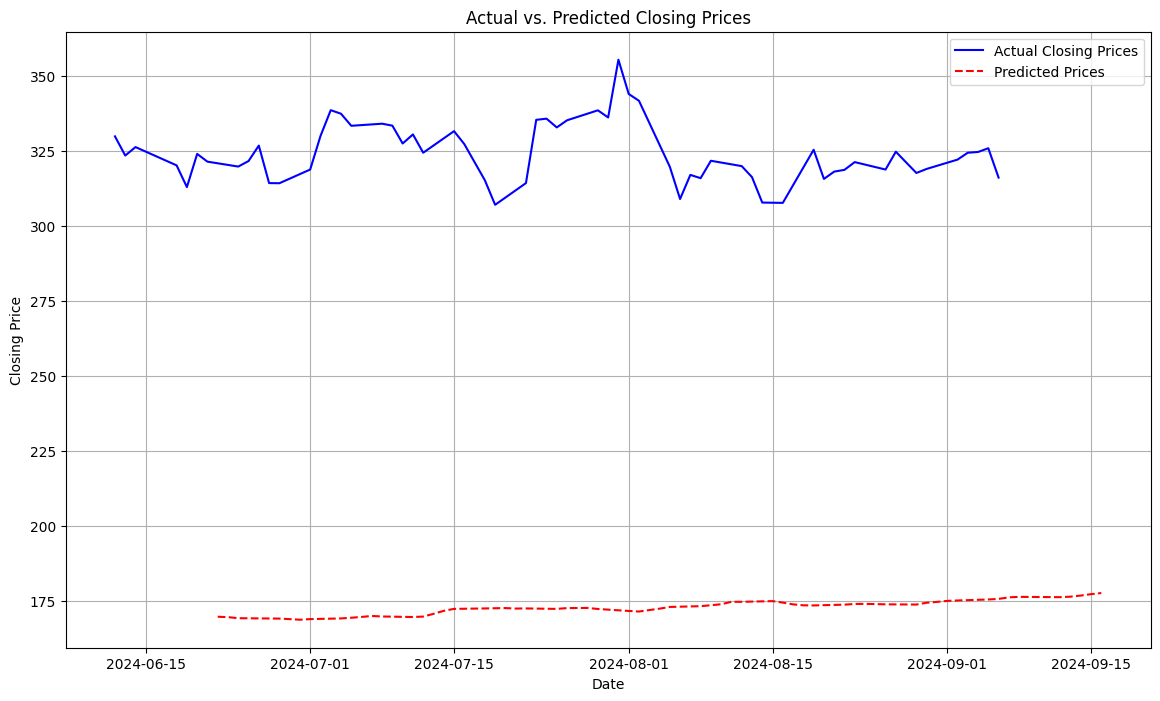

In [56]:
# Create an empty DataFrame to store predictions
predictions_df = pd.DataFrame(columns=['Predicted'])

# Total data length needed: Last 120 rows of the company DataFrame
total_length = 120

last_ind = len(company_original)-1 
# Ensure that there's enough data for creating sequences
if len(company_original) < total_length:
    raise ValueError("Not enough data to form the required sequences.")


# Iterate through the range to make predictions
for i in range(last_ind - time_steps + 1, last_ind + 1):
    # Form the sequence from time_steps before the current position i
    input_sequence = company_original[features].iloc[i - time_steps:i].values
    
    # Scale the input sequence using the previously fitted scaler
    input_sequence_scaled = scaler_X.transform(input_sequence)
    
    # Reshape to match the LSTM model's input shape (1, time_steps, num_features)
    input_sequence_scaled = input_sequence_scaled.reshape((1, time_steps, len(features)))
    
    # Predict the 10th day ahead price
    predicted_value_scaled = model.predict(input_sequence_scaled)
    
    # Inverse transform the predicted value to the original scale
    predicted_value = scaler_y.inverse_transform(predicted_value_scaled).flatten()[0]
    
    # Set the index of the predicted value to be 10 days ahead of the current position's index
    prediction_date = company_original.index[i] + pd.Timedelta(days=10)
    
    # Store the prediction with the adjusted index
    predictions_df.loc[prediction_date] = predicted_value

# Plotting
plt.figure(figsize=(14, 8))

# Plot the actual closing prices for the last 60 days
plt.plot(company_original.index[-60:], company_original['Close'].iloc[-60:], label='Actual Closing Prices', color='blue')

# Plot the predicted values (adjusted to the correct index positions)
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted Prices', color='red', linestyle='--')

# Add titles and labels
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()